# Traffic Sign Recognition Classifier
##### Self-Driving Car Engineer Nanodegree

### Prerequists

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import tensorflow as tf
import pandas as pd
from PIL import Image
from IPython.display import display, HTML

%matplotlib inline

---
## Load The Data

To download and load the data I made two small functions and added them to my datasets.py module: https://github.com/glazari/datasets. The idea behind this repo is that Deep Learning has many recurring datasets and they all have different methods for downloading and extracting the files, so this repo provides a common API to acess them. (Its still under development)

In [1]:
import datasets

train_set, val_set, test_set = datasets.load_Traffic_Sings()

train_x, train_y = train_set
val_x, val_y = val_set
test_x, test_y = test_set

---

## Dataset Summary & Exploration


Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43

Sample Images


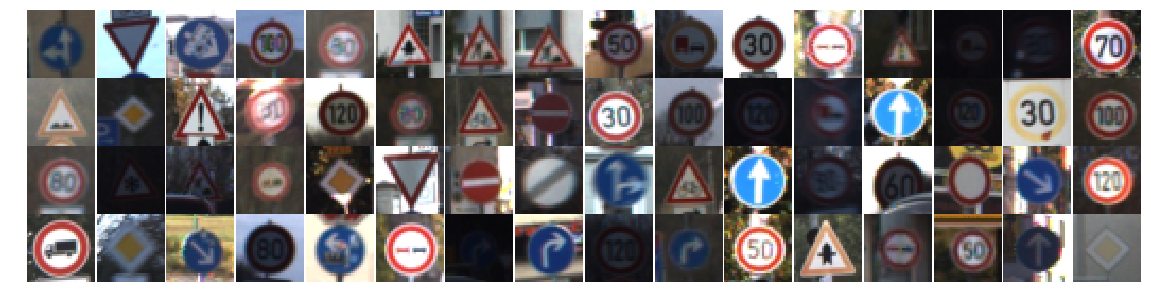

In [217]:
#dataset specs
n_train = len(train_x)
n_validation = len(val_x)
n_test = len(test_x)
image_shape = train_x[0].shape
n_classes = len(set(train_y))
print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


#view sample images
def view_samples(Imgs, title='Sample Images', size=64):
    print('\n'+title)
    n = len(Imgs)
    sample_i = np.random.choice(n, 64)
    samples = Imgs[sample_i]

    n = len(samples)

    plt.figure(figsize=(20,5))
    for i in range(n):
        plt.subplot(4,16,i+1)
        plt.imshow(samples[i])
        plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig(title+'.png')
    plt.show()

view_samples(train_x, title='Sample Images', size=64)

The images above give us a sense of how big (or actualy small) these images are. They also give us a sense of how dificult some of these images are to classify.

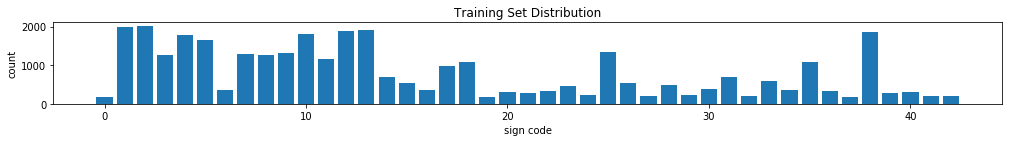

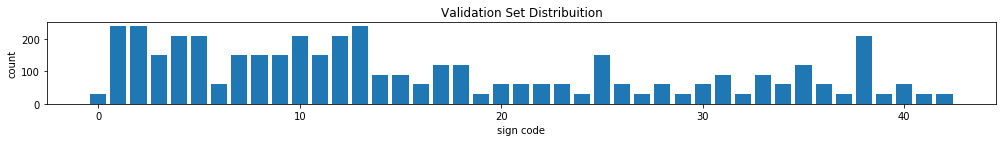

In [210]:
#Histogram of classes distribution
def hist_classes(labels, name=''):
    unique, counts = np.unique(labels, return_counts=True)
    plt.figure(figsize=(17,1.5))
    plt.bar(unique, counts)
    plt.title(name)
    plt.xlabel('sign code')
    plt.ylabel('count')
    plt.savefig(name+'_classes_histogram.png')
    plt.show()
hist_classes(train_y, 'Training Set Distribution')
hist_classes(val_y, 'Validation Set Distribuition')

The histograms above show us the frequency of accurance of each sign code in this dataset. It is instantly obvious that some classes are more common than others. If this was too scewed, if for example a class represented 80% of the cases, then we would have to try to balance out the classes. In our case the difference is not so alarming. But one precaution that is still necessary is to check that the traning data has about the same distribution as the real world. We don't have access to the real world and checking things on the test set is just cheating, so we take a look at the distribution of the validation set. The histograms above show that the distributions are very similar, so we need not worry about this.

----

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set

It is common to preprocess the datasets to make things a bit easier for the model. For example, if you want your model to be rotation insensitive, train it with random rotations. If you want it to be insensitive to color, you gray scale the image. Normalizing the image gives the information of which pixels are above the average and which are below the average without it having to be learned. For this model I used Normalization and rotation. I tried to use grayscale, but it did not seem to help. Also, color seems to be important in the task of classifying signs.

1. Normalize
2. Gray Scale (Discarted)
3. Rotation

Obs: grayscaling of an image is basicaly a 1x1 convolution with predifined weights. So a simillar operation could be learned by the model.

In [14]:
#processing functions
set_mean  = np.mean(train_x)
set_sigma = np.std(train_x)

def normalize(Xs):
    #normalize by training data mean and sigma
    Xs = (Xs - set_mean)/set_sigma
    return Xs

def unormalize(Xs):
    Xs = Xs*set_sigma + set_mean
    Xs = Xs/255
    Xs = Xs - np.min(Xs)
    Xs = Xs/np.max(Xs)
    return Xs

def random_rotate(images, degrees=15):
    n = len(images)
    for i in range(n):
        d = np.random.uniform(-degrees,degrees)
        images[i] = ndimage.rotate(images[i], d, reshape=False)
    return images

def rgb2gray(images):
    n = len(images)
    grays=[]
    for image in images:
        r, g, b = image[:,:,0], image[:,:,1], image[:,:,2]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
        grays.append(gray)
    
    grays = np.array(grays)
    grays = np.reshape(grays, (n,32,32,1))
    return grays

def pre_process(Xs,Ys):
    Xs = normalize(Xs)
    #Xs = rgb2gray(Xs)
    rotate1 = random_rotate(Xs, degrees=15)
    
    Xs = np.concatenate((Xs,rotate1),axis=0)
    Ys = np.concatenate((Ys,Ys),axis=0)
    return Xs, Ys

def pre_process_val(Xs,Ys):
    Xs = normalize(Xs)
    #Xs = rgb2gray(Xs)
    return Xs, Ys

#pre processing each of the datasets
train_im, train_label = pre_process(train_x, train_y)
val_im, val_label = pre_process_val(val_x, val_y)
test_im, test_label = pre_process_val(test_x, test_y)

image_shape = train_im[0].shape

#view sample processed images
ims = unormalize(train_im)
view_samples(ims, title='Sample Pre-Processed Images', size=64)


Sample Pre-Processed Images


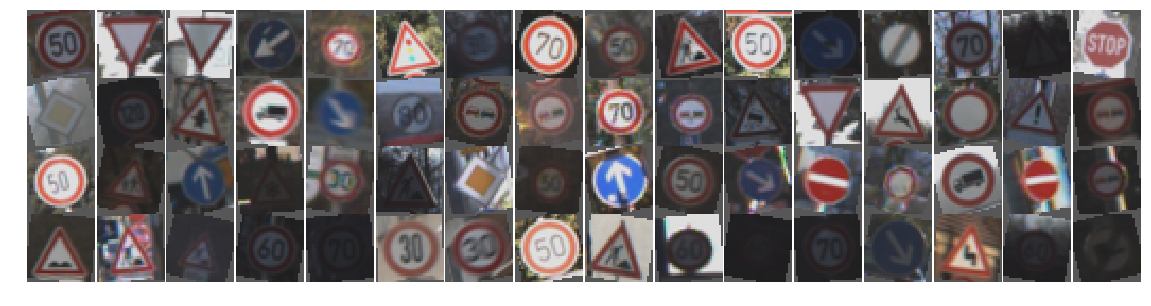

### Model Architecture

For every layer you want to add to your model you need to perform a few task. Like creating and initializing weights, setting input size and output size, adding l2_loss for those weights. The following functions abstract some of these tasks so that we can create the with less confusion.

In [17]:
#Functions to abstract the creation of layers
sigmoid = tf.nn.sigmoid
relu = tf.nn.relu
elu = tf.nn.elu

def bias(size, zero=False):
    if zero:
        return tf.Variable(tf.zeros([size], dtype=tf.float32))
    else:
        return tf.Variable(tf.random_normal([size], stddev=0.1))

def conv(tensor, n_out, ksize=3, stride=1):
    in_shape = tensor.shape.as_list()
    n_in = in_shape[-1]
    kernels = tf.Variable(tf.random_normal([ksize, ksize, n_in, n_out],  stddev=0.1))
    loss = tf.nn.l2_loss(kernels)
    tf.add_to_collection('l2_losses', loss)
    return tf.nn.conv2d(tensor,kernels, strides=[1, stride, stride, 1], padding='SAME') + bias(n_out)

def dense(tensor, n_out):
    in_shape = tensor.shape.as_list()
    n_in = in_shape[-1]
    weights = tf.Variable(tf.random_normal(shape=(n_in, n_out), mean=0, stddev=0.1))
    loss = tf.nn.l2_loss(weights)
    tf.add_to_collection('l2_losses', loss)
    return tf.matmul(tensor, weights) + bias(n_out)

def max_pool(tensor, ksize=3, stride=1):
    return tf.nn.max_pool(tensor, ksize=[1,ksize,ksize,1], strides=[1,stride,stride,1], padding='SAME')

def flatten(tensor):
    dim = tensor.shape.as_list()
    size = np.product(dim[1:])
    print(size)
    flat = tf.reshape(tensor, [-1, size])
    return flat

Below is the actual model architecture.

In [19]:
#Model specs
n1 = 64
n2 = 64
n3 = 384
n4 = 192

#Model
x = tf.placeholder(tf.float32, [None, 32, 32, 3],'X')
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

conv1 = elu(conv(x,n_out=n1, ksize=5, stride=1))
conv1 = max_pool(conv1,ksize=3,stride=2)
conv2 = elu(conv(conv1,n_out=n2, ksize=5, stride=1))
conv2 = max_pool(conv2,ksize=3,stride=2)
flat = flatten(conv2)
dense1 = elu(dense(flat, n_out=n3))
dense2 = elu(dense(dense1, n_out=n4))
logits = dense(dense2, n_out=n_classes)

4096


And below here is the model loss function and accuracy operation.

In [20]:
#loss function
rate = 0.001

l2_loss = tf.reduce_sum(tf.get_collection('l2_losses'))
C = tf.Variable(tf.constant(0.00002),trainable=False)
C_ph = tf.placeholder(tf.float32)
C_assign = tf.assign(C, C_ph)


cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy) + C*l2_loss
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
train_step = optimizer.minimize(loss_operation)

#Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

init = tf.global_variables_initializer()
saver = tf.train.Saver()

### Train, Validate and Test the Model

Here we will train our model on the training set, evaluate it on our validation set. Make some improvements and repeat the process. Only after all tweaking is finished do we test our results on the test set.

In [21]:
sess = tf.Session()

In [25]:
#run epoch
def run_epoch(xs, ys, train=True, batch_size=128):
    avg_loss = 0.
    avg_acc = 0.
    for batch_xs, batch_ys in datasets.batches(xs, ys, batch_size=batch_size):
        feed_dict = {x: batch_xs, y: batch_ys}
        if train:
            opt, loss, acc = sess.run((train_step,loss_operation,accuracy_operation),
                                     feed_dict=feed_dict)
        else:
            loss, acc = sess.run((loss_operation, accuracy_operation),
                                feed_dict=feed_dict)
        n = len(xs)
        n_batch = len(batch_xs)
        avg_loss += loss / n * n_batch
        avg_acc += acc / n * n_batch
    return avg_loss, avg_acc

def set_C(val):
    sess.run(C_assign, feed_dict={C_ph:val})
    
def train(Xs, Ys, val_Xs, val_y, C_val=0.001, training_epochs=5, 
          display_step=5, batch_size=128,save=False):
    stats = "EPOCH %03d, LOSS: %.5f, ACC: %.5f, VAL_LOSS: %.5f, VAL_ACC: %.5f, l2: %.5f"
    sess.run(init)
    max_val_acc = 0
    set_C(C_val)
    val_losses = []
    losses = []
    val_accs = []
    accs = []
    for epoch in range(training_epochs):
        train_loss, train_acc = run_epoch(Xs, Ys)
        val_loss, val_acc = run_epoch(val_Xs, val_y, train=False)

        val_losses.append(val_loss)
        losses.append(train_loss)
        val_accs.append(val_acc)
        accs.append(train_acc)

        l2 = sess.run(l2_loss)
        if val_acc > max_val_acc and save:
            print('saving model', val_acc)
            max_val_acc = val_acc
            save_path = saver.save(sess, "./model_c2.ckpt")
        #Display every 'display_step' steps
        if epoch % display_step == 0:
            print(stats % (epoch+1, train_loss, train_acc, val_loss, val_acc, l2))
    if epoch % display_step != 0:
        print(stats % (epoch+1, train_loss, train_acc, val_loss, val_acc, l2))
    
    return losses, val_losses, accs, val_accs

Our model uses l2_loss. That is to say that besides the loss on the prediction error we also ad a loss that is proportional to the square of the magnitude of the wieghts. This loss is mean to help regularize the model. Another way of viewing this is that we force a weight to be close to zero unless it has high significance. The problem with add this loss is that you have to decide apon a proportion between the prediction loss and the regularization loss.
For this we test different proportions and then choose the best.

In [21]:
#find best C
max_C = None
max_val_acc = 0
Cs = np.logspace(-10.0, -13, 10, base = 2, dtype = np.float32)
for C_val in Cs:
    print('####### C %.7f #######' % C_val)
    results = train(gray_train_x, gray_train_y, gray_val_x, gray_val_y, 
                    C_val=C_val, training_epochs=20, display_step=5, batch_size=128)
    losses, val_losses, accs, val_accs = results
    
    if max(val_accs) > max_val_acc:
        max_val_acc = max(val_accs)
        max_C = C_val
    print('Max val acc %.5f', max(val_accs))

print('\nMax val acc ', max_val_acc, 'C', max_C)

####### C 0.0009766 #######
EPOCH: 0001, LOSS: 10.25280, ACC: 0.71673, VAL_LOSS: 7.78383, VAL_ACC: 0.74286, l2: 6826.33105
EPOCH: 0006, LOSS: 1.29577, ACC: 0.99093, VAL_LOSS: 1.33777, VAL_ACC: 0.92109, l2: 1052.04956
EPOCH: 0011, LOSS: 0.27233, ACC: 0.99007, VAL_LOSS: 0.47221, VAL_ACC: 0.93787, l2: 256.15500
EPOCH: 0016, LOSS: 0.21522, ACC: 0.98760, VAL_LOSS: 0.28415, VAL_ACC: 0.96599, l2: 154.29260
EPOCH: 0020, LOSS: 0.19864, ACC: 0.98714, VAL_LOSS: 0.29709, VAL_ACC: 0.96349
Max val acc %.5f 0.965986394315
####### C 0.0007751 #######
EPOCH: 0001, LOSS: 8.06866, ACC: 0.73412, VAL_LOSS: 6.08000, VAL_ACC: 0.77052, l2: 6620.36279
EPOCH: 0006, LOSS: 0.88302, ACC: 0.99007, VAL_LOSS: 1.07611, VAL_ACC: 0.90476, l2: 904.64008
EPOCH: 0011, LOSS: 0.20870, ACC: 0.99497, VAL_LOSS: 0.47008, VAL_ACC: 0.92540, l2: 226.64220
EPOCH: 0016, LOSS: 0.19352, ACC: 0.98714, VAL_LOSS: 0.37136, VAL_ACC: 0.96304, l2: 191.53503
EPOCH: 0020, LOSS: 0.12374, ACC: 0.99478, VAL_LOSS: 0.50305, VAL_ACC: 0.91746
Max val 

Once chosen the best proportion C, we train for a longer time and se what happens.

saving model 0.738095237501
EPOCH: 0001, LOSS: 2.67358, ACC: 0.68812, VAL_LOSS: 2.09441, VAL_ACC: 0.73810, l2: 8474.93457
saving model 0.814965986259
saving model 0.848979591918
saving model 0.863945577474
saving model 0.907029477701
EPOCH: 0006, LOSS: 0.73874, ACC: 0.99017, VAL_LOSS: 1.30291, VAL_ACC: 0.90703, l2: 5424.79199
saving model 0.932879818108
EPOCH: 0011, LOSS: 0.38710, ACC: 0.99356, VAL_LOSS: 0.92237, VAL_ACC: 0.91701, l2: 2752.34717
saving model 0.933333333117
saving model 0.948752834251
saving model 0.953287981373
EPOCH: 0016, LOSS: 0.19343, ACC: 0.99833, VAL_LOSS: 0.47903, VAL_ACC: 0.94671, l2: 1388.99512
saving model 0.958049886892
saving model 0.963038548239
EPOCH: 0021, LOSS: 0.14185, ACC: 0.99741, VAL_LOSS: 0.35234, VAL_ACC: 0.96304, l2: 993.09070
saving model 0.965079364322
saving model 0.967346938019
EPOCH: 0026, LOSS: 0.10952, ACC: 0.99947, VAL_LOSS: 0.25314, VAL_ACC: 0.96735, l2: 773.39661
saving model 0.969841269328
saving model 0.973696144098
EPOCH: 0031, LOSS:

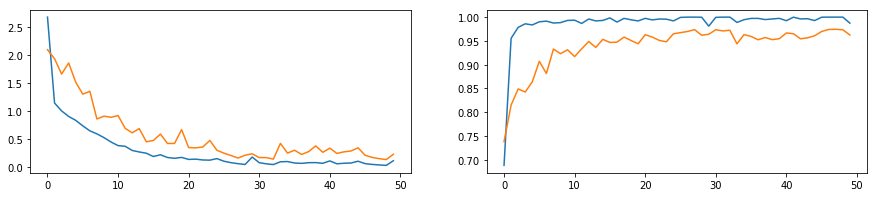

CPU times: user 6min 8s, sys: 1min, total: 7min 9s
Wall time: 8min 32s


In [26]:
%%time
#train with chosen C for more epochs
results = train(train_im, train_label, val_im, val_label, 
                    C_val=0.00012207, training_epochs=50, display_step=5, batch_size=128, save=True)

losses, val_losses, accs, val_accs = results

print('Max val acc %.5f', max(val_accs))

plt.figure(figsize=(15,3))
plt.subplot(121)
plt.plot(losses)
plt.plot(val_losses)
plt.subplot(122)
plt.plot(accs)
_ = plt.plot(val_accs)
plt.show()

In [27]:
#test
test_loss, test_acc = run_epoch(test_im, test_label, train=False, 
                                augment=False, batch_size=128)
print(test_acc)

0.948772763073


### l2 loss
ls loss is the square of the norm of the weights. In other words it is a measure of how big the weights are. At first sight it may not be evident why penilizing large weights could be helpful, if anything, it seems like it would be bad, as it penalises something that is not directly related to the accuracy. But l2 loss have been empiricaly shown to be a good regularization method. And there are theoretical justifications as well.
 
    total_loss = loss + C*l2_loss

Lets try to take an intuitive look at it. Lets imagin that there is no penalization for the weight size. Since the model starts out at random then there is a chance that in the begining an irrelavent feature has a high weight. The model has two ways to correct this, either it lowers the weights of the irrelevant feature, which is what we want. Or it does the unintuitive thing of raising another irrelevant feature's weigh in the oposite direction so that they cancel each other out. Although they both work they are not equaly good options. The l2 loss tells the model that lowering the size of the wiehgts is better than "compansating" with other weights. This also helps generalization as irrelivent features end up being ignored quicker.

With that said, there is still the question of how much should you penalize the weights. Penalize too much and you get a model with zero weihgts and no acc, too little and you might as well not have the penalization. To choose just how much we try out different Cs and check the validation acc we can acheive.

Note: since the loss for different Cs will have different weights for the l2_loss, it is no longer reliable to compare loss between these tests, that is why we compare acc.

Below are a few of the test for choosing C

    C = 0.001    -> 0.94
    C = 0.0004   -> 0.97
    C = 0.0003   -> 0.97
    C = 0.0002   -> 0.98
    C = 0.0001   -> 0.968
    C = 0.000075 -> 0.972
    C = 0.00005  -> 0.965
    C = 0.00001  -> 0.92

---

## Step 3: Test a Model on New Images


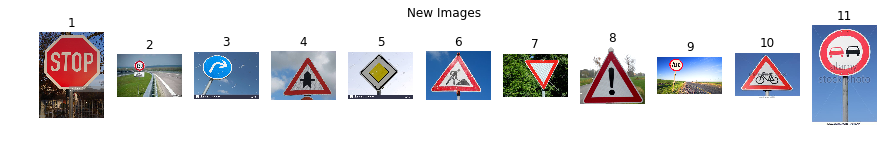

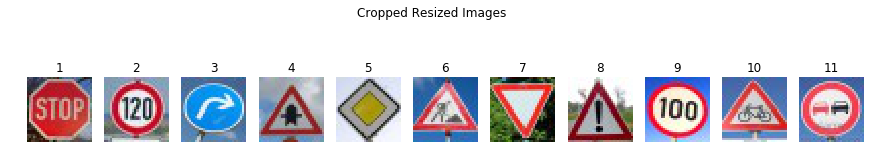

In [103]:
### Load the images and plot them here.
new_signs = os.listdir('New_Signs/')
new_signs = [im for im in new_signs if 'Cropped' not in im]
ims = []
for sign in new_signs:
    im = Image.open('New_Signs/'+sign)
    ims.append(np.array(im.getdata()).reshape(im.size[1], im.size[0], 3).astype('ubyte'))

plt.figure(figsize=(15,2))
plt.suptitle('New Images')
n = len(ims)
for i, im in enumerate(ims):
    plt.subplot(1,n,i+1)
    plt.imshow(im)
    plt.title(i+1)
    plt.axis('off')

### Resized and croped images
new_signs = os.listdir('New_Signs/Cropped/')
ims = []
for sign in new_signs:
    im = Image.open('New_Signs/Cropped/'+sign)
    ims.append(np.array(im.getdata()).reshape(im.size[1], im.size[0], 3).astype('ubyte'))

plt.figure(figsize=(15,3))
plt.suptitle('Cropped Resized Images')
n = len(ims)
for i, im in enumerate(ims):
    plt.subplot(1,n,i+1)
    plt.imshow(im)
    plt.title(i+1)
    plt.axis('off')

In [207]:
### Run the predictions here and use the model to output the prediction for each image.
new_images = np.array(ims)
def prediction(ims):
    log = sess.run(logits, feed_dict={x: ims})
    predictions = np.argmax(log,axis=1)
    
    sign_names = pd.DataFrame.from_csv('signnames.csv')
    names = sign_names['SignName']
    names = [names[i] for i in predictions]
    
    return  names
pred_names = prediction(ims)

correct_names = ['Stop', 'Speed limit (120km/h)', 'Turn right ahead',
                 'Right-of-way at the next intersection', 'Priority road', 'Road work',
                 'Yield', 'General caution','Speed limit (100km/h)','Bicycles crossing',
                 'No passing']

df = pd.DataFrame({'prediction':pred_names, 'correct':correct_names}, index=range(1,12))
display(df[['prediction','correct']])

print('Accuracy is 9 out of 11: %.3f'%(9/11))

,prediction,correct
1,Stop,Stop
2,Speed limit (120km/h),Speed limit (120km/h)
3,Turn right ahead,Turn right ahead
4,Right-of-way at the next intersection,Right-of-way at the next intersection
5,Priority road,Priority road
6,Road work,Road work
7,Yield,Yield
8,General caution,General caution
9,Speed limit (80km/h),Speed limit (100km/h)
10,Speed limit (60km/h),Bicycles crossing


Accuracy is 9 out of 11: 0.818


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [142]:
#difine tensorflow operations
top_5 = tf.nn.top_k(logits, k=5, sorted=True)
softmax = tf.nn.softmax(logits)
softmax_top_5 = tf.nn.softmax(top_5.values)
in_top_5 = tf.nn.in_top_k(logits, y, k=5)

It just so happens that our model is so "sure" of itself that all of the probabilities are 0 except for the one that it acutaly chooses. This seems like a sign of overfitting though I have never heard of this happening. 

In [146]:
st5 = sess.run(softmax_top_5, feed_dict={x: ims})
st5

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.]], dtype=float32)

Because of this we will look at the top 5 logits instead

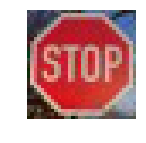

,Class,Score
0,Stop,2311.709961
1,Bicycles crossing,1108.522461
2,Speed limit (20km/h),887.223999
3,Speed limit (80km/h),630.309814
4,No passing for vehicles over 3.5 metric tons,485.134491


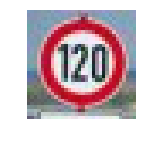

,Class,Score
0,Speed limit (120km/h),1885.135498
1,Speed limit (20km/h),1411.905640
2,Speed limit (80km/h),1068.148071
3,Stop,808.873230
4,Speed limit (60km/h),767.201294


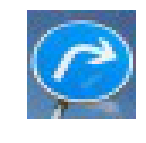

,Class,Score
0,Turn right ahead,2137.726074
1,Ahead only,1577.217651
2,Roundabout mandatory,729.606995
3,Go straight or left,718.924072
4,Turn left ahead,593.351929


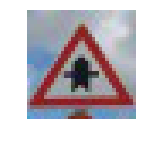

,Class,Score
0,Right-of-way at the next intersection,4321.302246
1,End of no passing by vehicles over 3.5 metric ...,2045.920776
2,Beware of ice/snow,1468.925049
3,Pedestrians,1380.131836
4,Traffic signals,1278.528564


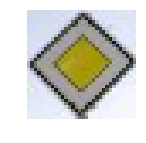

,Class,Score
0,Priority road,3985.638428
1,No entry,1411.094604
2,No passing for vehicles over 3.5 metric tons,957.394348
3,End of no passing by vehicles over 3.5 metric ...,879.067078
4,Go straight or left,773.647766


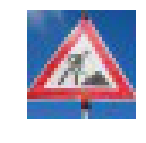

,Class,Score
0,Road work,2613.195801
1,Road narrows on the right,1418.762207
2,Go straight or right,882.919067
3,Turn right ahead,877.780151
4,Dangerous curve to the right,754.667114


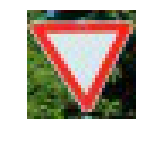

,Class,Score
0,Yield,3067.740479
1,Priority road,1703.646973
2,Bumpy road,1057.870117
3,Stop,1056.437744
4,No entry,886.845642


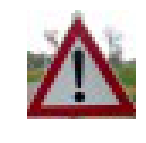

,Class,Score
0,General caution,4043.002197
1,Traffic signals,2025.318359
2,Pedestrians,1776.505859
3,Speed limit (70km/h),1490.844482
4,Road narrows on the right,796.646729


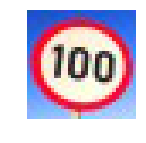

,Class,Score
0,Speed limit (80km/h),1639.368530
1,Speed limit (50km/h),1021.629089
2,Speed limit (100km/h),891.078430
3,Speed limit (70km/h),838.066650
4,Speed limit (60km/h),821.688110


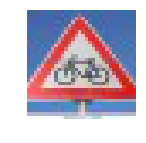

,Class,Score
0,Speed limit (60km/h),1370.328979
1,Children crossing,782.294006
2,Speed limit (80km/h),733.621948
3,Right-of-way at the next intersection,696.520630
4,Beware of ice/snow,644.288635


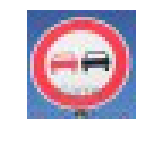

,Class,Score
0,No passing,1581.371338
1,Vehicles over 3.5 metric tons prohibited,1389.653442
2,No entry,958.248779
3,End of no passing,719.297729
4,No passing for vehicles over 3.5 metric tons,635.121643


In [187]:
lt5 = sess.run(top_5, feed_dict={x: ims})
values = lt5.values
classes = lt5.indices


names = sign_names['SignName']
i = 0
for i in range(len(ims)):
    v = values[i]
    c = classes[i]
    df = pd.DataFrame(columns=('Class','Score'))
    plt.figure(figsize=(2,2))
    plt.imshow(ims[i])
    plt.axis('off')
    plt.show()
    for j in range(5):
        names[c[j]]
        df.loc[j]=(names[c[j]],v[j])
    display(df)